In [59]:
import pandas as pd
from typing import Optional
from IPython.utils import io
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
file_name = "train_cleaned.csv"
df = pd.read_csv(file_name)

In [61]:
df.head()

,month,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,...,has_auto_loan,has_credit_builder_loan,has_debt_consolidation_loan,has_home_equity_loan,has_mortgage_loan,has_not_specified,has_payday_loan,has_personal_loan,has_student_loan,credit_history_months
0,January,23,19114.12,1824.843333,3,4,3.0,4,3,7,...,1,1,0,1,0,0,0,1,0,265
1,February,23,19114.12,3093.745000,3,4,3.0,4,-1,14,...,1,1,0,1,0,0,0,1,0,219
2,March,18,19114.12,3093.745000,3,4,3.0,4,3,7,...,1,1,0,1,0,0,0,1,0,267
3,April,23,19114.12,3093.745000,3,4,3.0,4,5,4,...,1,1,0,1,0,0,0,1,0,268
4,May,23,19114.12,1824.843333,3,4,3.0,4,6,14,...,1,1,0,1,0,0,0,1,0,269


Here is a **feature engineering checklist** tailored to your dataset (`train_cleaned.csv`):

---

## **Feature Engineering Checklist**

### **2. Derived Numeric Ratios**

Add ratios to capture relationships:

* [ ] `income_to_emi_ratio = annual_income / (total_emi_per_month * 12)`
* [ ] `income_to_debt_ratio = annual_income / (outstanding_debt + 1)`
* [ ] `salary_to_loan_ratio = monthly_inhand_salary / (num_of_loan + 1)`
* [ ] `investment_to_salary_ratio = amount_invested_monthly / (monthly_inhand_salary + 1)`

---

### **3. Behavioral / Credit Usage Features**

* [ ] `avg_delay_days = delay_from_due_date / (num_of_delayed_payment + 1)`
* [ ] `credit_inquiries_per_loan = num_credit_inquiries / (num_of_loan + 1)`
* [ ] `loan_to_credit_card_ratio = num_of_loan / (num_credit_card + 1)`
* [ ] `credit_utilization_bucket = pd.qcut(credit_utilization_ratio, q=4, labels=False)` *(for tree models)*
* [ ] Binary flag: `is_high_utilization = (credit_utilization_ratio > 0.8)`

---

### **4. Credit History Transformations**

* [ ] Convert `credit_history_months` to numeric if not already.
* [ ] Derive:

  * `credit_history_years = credit_history_months / 12`
  * `short_credit_history = (credit_history_months < 24)`

---

### **5. Aggregation Features (per customer, if applicable)**

If dataset contains multiple months per customer:

* [ ] Aggregate historical stats:

  ```python
  df_agg = df.groupby("customer_id").agg({
      "monthly_inhand_salary": ["mean", "std"],
      "num_of_loan": "mean",
      "num_of_delayed_payment": "sum",
      "outstanding_debt": "mean"
  }).reset_index()
  ```
* [ ] Merge aggregates back for next-period prediction.

---

### **6. Encoding Review**

Already present:

* Occupation one-hot (`occ_*`)
* Credit mix (`credit_mix_*`)
* Payment behaviour (`pay_beh_*`)
* Loan type flags (`has_*`)
* Payment of minimum (`payment_min_*`)

✅ No extra encoding required unless you add new categorical variables.

---

### **7. Outlier and Scaling Step**

* [ ] Log-transform skewed numeric columns:

  ```python
  skewed = ['outstanding_debt', 'annual_income', 'amount_invested_monthly']
  for col in skewed:
      df[col] = np.log1p(df[col])
  ```
* [ ] Normalize or standardize continuous variables for models sensitive to scale (e.g., Logistic Regression).

---

### **8. Feature Selection / Predictive Signal**

After feature creation:

* [ ] Train baseline model (e.g., XGBoost or RandomForest)
* [ ] Evaluate **feature importance**:

  ```python
  from sklearn.inspection import permutation_importance
  r = permutation_importance(model, X, y, n_repeats=5)
  ```
* [ ] Drop low-importance or redundant (correlated) features:

  ```python
  corr = X.corr().abs()
  high_corr = [col for col in corr.columns if any(corr[col] > 0.9)]
  ```

---

### **9. Monitoring-Ready Features**

* [ ] Keep summary stats (mean, std, missing count) for key features
* [ ] Define drift thresholds (e.g., PSI > 0.2 → retrain trigger)

---

Would you like me to output this as a **ready-to-run notebook skeleton (Python code)** that implements each section?


Credit Score by Month:
              mean       std  count
month_num                          
1          1.87144  0.654268  12500
2          1.87816  0.655431  12500
3          1.87464  0.653543  12500
4          1.89496  0.686414  12500
5          1.88784  0.684995  12500
6          1.89072  0.689417  12500
7          1.90376  0.687587  12500
8          1.90488  0.687161  12500

Variance across months: 0.0002


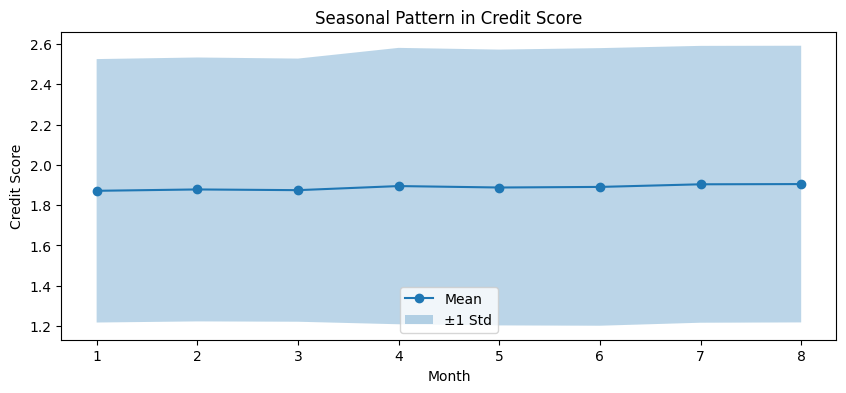

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Encode credit_score as numeric
credit_score_map = {'Poor': 1, 'Standard': 2, 'Good': 3}
df['credit_score_numeric'] = df['credit_score'].map(credit_score_map)

# Convert month string to number for analysis
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['month_num'] = df['month'].map(month_map)

# Check seasonal signal using numeric credit score
monthly_stats = df.groupby('month_num')['credit_score_numeric'].agg(['mean', 'std', 'count'])
print("Credit Score by Month:")
print(monthly_stats)
print(f"\nVariance across months: {monthly_stats['mean'].var():.4f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_stats.index, monthly_stats['mean'], marker='o', label='Mean')
plt.fill_between(monthly_stats.index, 
                 monthly_stats['mean'] - monthly_stats['std'],
                 monthly_stats['mean'] + monthly_stats['std'],
                 alpha=0.3, label='±1 Std')
plt.xlabel('Month')
plt.ylabel('Credit Score')
plt.title('Seasonal Pattern in Credit Score')
plt.legend()
plt.show()

In [63]:
# Decision: Drop month column (variance = 0.0002, no seasonal signal)
print("Monthly variance analysis:")
print("  Variance across months: 0.0002")
print("  Conclusion: Month has no predictive signal for credit_score")

df = df.drop(columns=['month', 'month_num'], errors='ignore')

Monthly variance analysis:
  Variance across months: 0.0002
  Conclusion: Month has no predictive signal for credit_score


### Derive features
Before adding derived features, we should compute correlation matrix.

In [64]:
multi_collinearity_threshold = 0.8

STEP 1: Baseline Correlation Analysis (Before Feature Engineering)

Top 15 Features Correlated with Credit Score:
credit_score_numeric           1.000000
credit_history_months          0.371374
monthly_balance                0.203042
monthly_inhand_salary          0.190763
amount_invested_monthly        0.146630
age                            0.137278
annual_income                  0.137168
credit_utilization_ratio       0.045793
total_emi_per_month            0.004586
interest_rate                 -0.007260
num_credit_inquiries          -0.016695
has_not_specified             -0.135134
has_home_equity_loan          -0.136328
has_student_loan              -0.139390
has_debt_consolidation_loan   -0.140383
Name: credit_score_numeric, dtype: float64


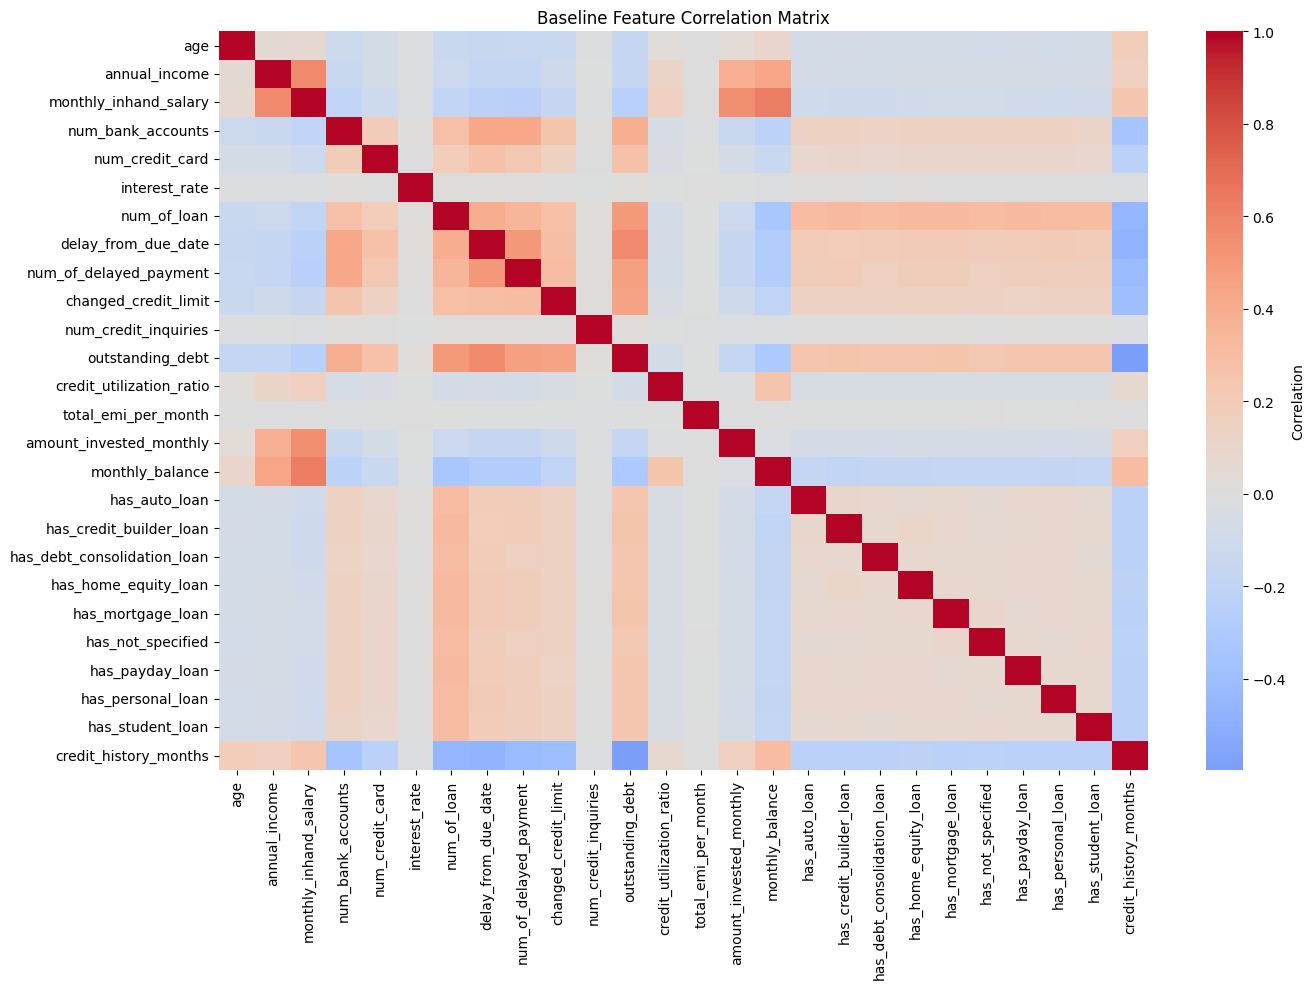


STEP 2: High Multicollinearity Detection (corr > 0.8)

Found 0 highly correlated pairs:
Empty DataFrame
Columns: [feature_1, feature_2, correlation]
Index: []


In [65]:
# Step 1: Visualize baseline correlations with target
print("=" * 60)
print("STEP 1: Baseline Correlation Analysis (Before Feature Engineering)")
print("=" * 60)

# Convert credit_score to numeric for correlation
credit_score_map = {'Poor': 1, 'Standard': 2, 'Good': 3}
df['credit_score_numeric'] = df['credit_score'].map(credit_score_map)

# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('credit_score_numeric')  # Separate target

# Compute correlation with target
correlations = df[numeric_cols + ['credit_score_numeric']].corr()['credit_score_numeric'].sort_values(ascending=False)

print("\nTop 15 Features Correlated with Credit Score:")
print(correlations.head(15))

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Baseline Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Step 2: Identify high multicollinearity pairs (before adding ratios)
print("\n" + "=" * 60)
print(f"STEP 2: High Multicollinearity Detection (corr > {multi_collinearity_threshold})")
print("=" * 60)

def find_high_correlation_pairs(corr_matrix, threshold=0.9):
    """Find feature pairs with correlation > threshold"""
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'feature_1': corr_matrix.columns[i],
                    'feature_2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })

    # Handle empty case
    if not high_corr_pairs:
        return pd.DataFrame(columns=['feature_1', 'feature_2', 'correlation'])

    return pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)

high_corr_baseline = find_high_correlation_pairs(corr_matrix, threshold=multi_collinearity_threshold)
print(f"\nFound {len(high_corr_baseline)} highly correlated pairs:")
print(high_corr_baseline)

Finding zero highly correlated pairs (threshold 0.8) is actually ideal for feature engineering. It means:
- No redundancy yet — Your baseline features are relatively independent
- Safe to add ratios — New derived features won't immediately create multicollinearity
- Maximum signal gain — Ratios will capture non-linear relationships without overlap

#### Proceed with Adding Derived Features

In [66]:
# Add Derived Numeric Ratios
print("\n" + "=" * 60)
print("Add Derived Numeric Ratios")
print("=" * 60)

# Financial health ratios
df['income_to_emi_ratio'] = df['annual_income'] / (df['total_emi_per_month'] * 12 + 1)
df['income_to_debt_ratio'] = df['annual_income'] / (df['outstanding_debt'] + 1)
df['salary_to_loan_ratio'] = df['monthly_inhand_salary'] / (df['num_of_loan'] + 1)
df['investment_to_salary_ratio'] = df['amount_invested_monthly'] / (df['monthly_inhand_salary'] + 1)

# Credit behavior ratios
df['avg_delay_days'] = df['delay_from_due_date'] / (df['num_of_delayed_payment'] + 1)
df['credit_inquiries_per_loan'] = df['num_credit_inquiries'] / (df['num_of_loan'] + 1)

# Credit utilization features
df['is_high_utilization'] = (df['credit_utilization_ratio'] > 0.8).astype(int)

# Verify no NaNs introduced
nan_counts = df.select_dtypes(include=[np.number]).isna().sum()
if nan_counts.sum() > 0:
    print(f"\nWarning: {nan_counts.sum()} NaN values found in numeric columns")
    print(nan_counts[nan_counts > 0])
else:
    print("\nNo NaN values in numeric columns")

print(f"\nNew dataset shape: {df.shape}")


Add Derived Numeric Ratios

No NaN values in numeric columns

New dataset shape: (100000, 63)



Multicollinearity Check (After Feature Engineering)

Found 0 highly correlated pairs (threshold 0.8):
✓ No high multicollinearity detected — safe to proceed!

New Features' Correlation with Target

Correlation of New Features with Credit Score:
credit_score_numeric          1.000000
salary_to_loan_ratio          0.219709
income_to_emi_ratio           0.104888
income_to_debt_ratio          0.046017
credit_inquiries_per_loan     0.011352
investment_to_salary_ratio   -0.027047
avg_delay_days               -0.099525
Name: credit_score_numeric, dtype: float64


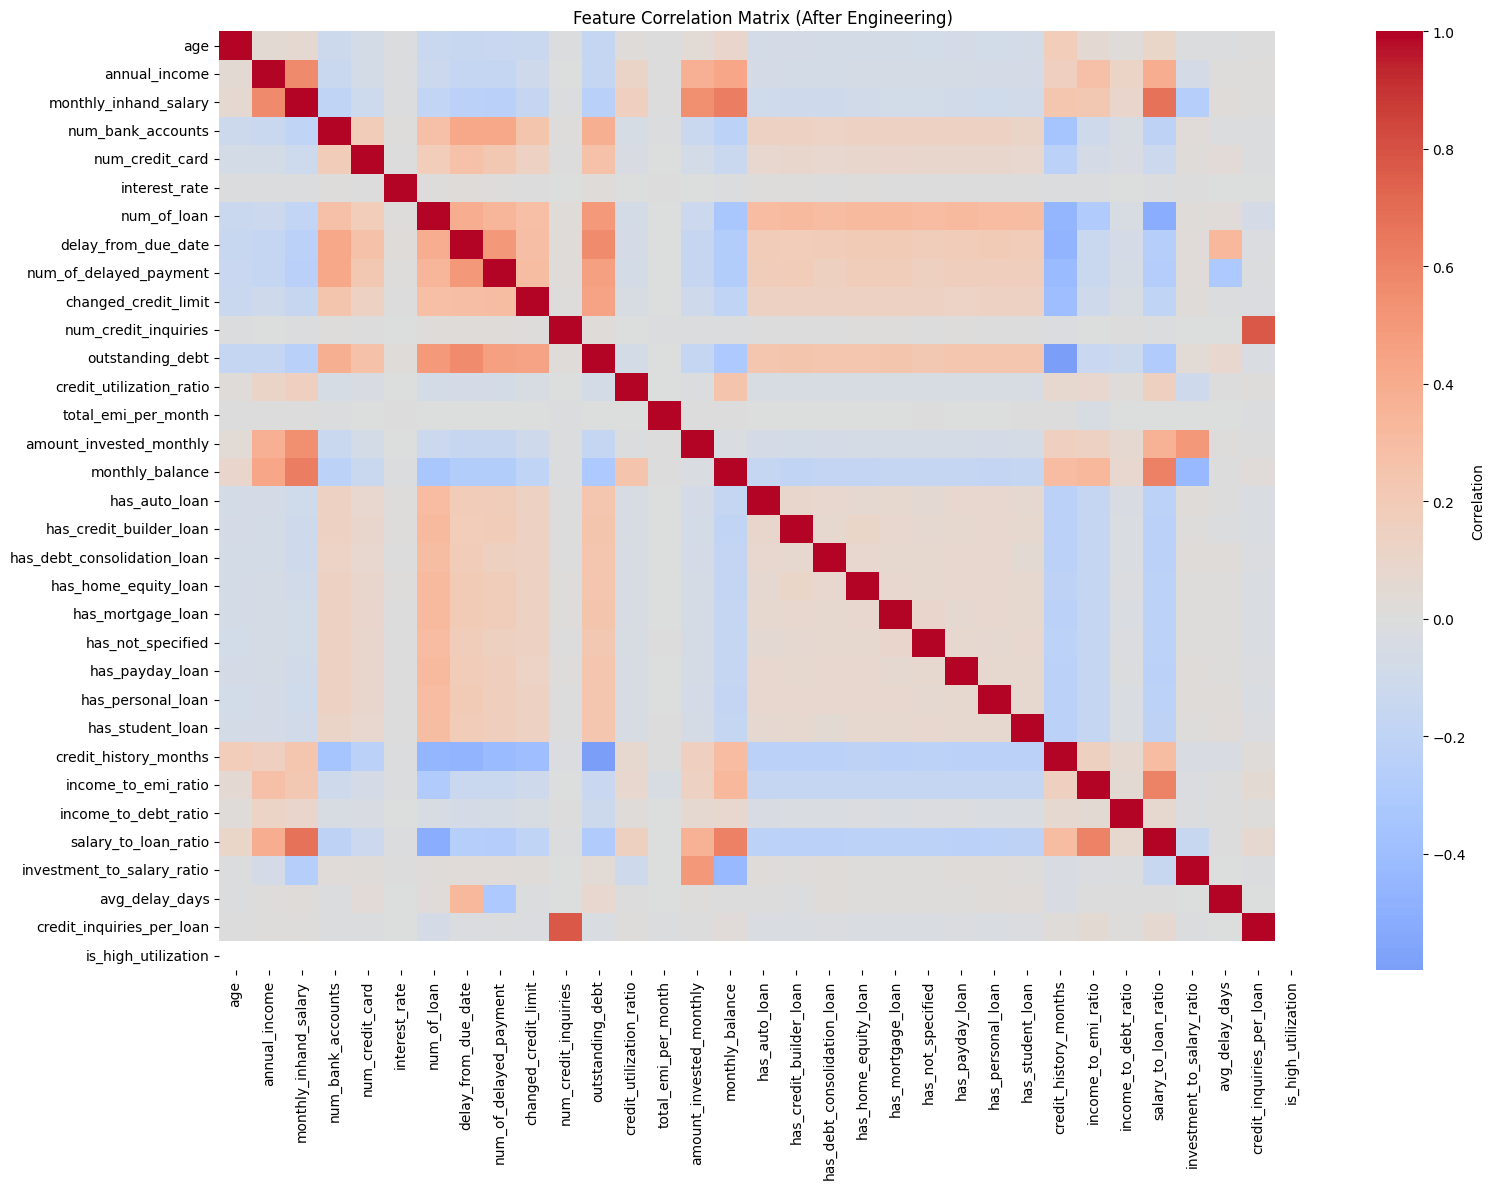

In [67]:
# Check multicollinearity after adding derived features
print("\n" + "=" * 60)
print("Multicollinearity Check (After Feature Engineering)")
print("=" * 60)

numeric_cols_after = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_after.remove('credit_score_numeric')

corr_matrix_after = df[numeric_cols_after].corr()
high_corr_after = find_high_correlation_pairs(corr_matrix_after, threshold=multi_collinearity_threshold)

print(f"\nFound {len(high_corr_after)} highly correlated pairs (threshold {multi_collinearity_threshold}):")
if len(high_corr_after) > 0:
    print(high_corr_after)
else:
    print("✓ No high multicollinearity detected — safe to proceed!")

# Check correlation of new features with target
print("\n" + "=" * 60)
print("New Features' Correlation with Target")
print("=" * 60)

new_features = [
    'income_to_emi_ratio', 'income_to_debt_ratio', 'salary_to_loan_ratio',
    'investment_to_salary_ratio', 'avg_delay_days', 'credit_inquiries_per_loan',
    'is_high_utilization'
]

new_feature_corrs = df[new_features + ['credit_score_numeric']].corr()['credit_score_numeric'].sort_values(ascending=False)

print("\nCorrelation of New Features with Credit Score:")
print(new_feature_corrs[:-1])  # Exclude credit_score_numeric itself

# Visualize updated correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_after, annot=False, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix (After Engineering)')
plt.tight_layout()
plt.show()